In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [2]:
sample_df = pd.read_csv("train.csv")

sample_df.shape

(1458644, 11)

In [3]:
sample_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


pickup_datetime and dropoff_datetime have to be converted from the type object to datetime. The store_and_fwd_flag column is a categorical column. We'll convert it to numeric value. 

## Data Preprocessing
Converting categorical feature to numeric

In [5]:
sample_df["store_and_fwd_flag"].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [6]:
f = lambda x: 0 if x == 'N' else 1
sample_df["store_and_fwd_flag"] = sample_df["store_and_fwd_flag"].apply(lambda x: f(x))  
sample_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435


In [7]:
sample_df["store_and_fwd_flag"].value_counts()

0    1450599
1       8045
Name: store_and_fwd_flag, dtype: int64

Converting object type to datetime.

In [8]:
sample_df["dropoff_datetime"] = pd.to_datetime(sample_df["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
sample_df["pickup_datetime"] = pd.to_datetime(sample_df["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')

In [9]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  int64         
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(4), object(1)
memory usage: 122.4+ MB


## Feature Engineering
Creating feature like month, date, hour and minutes from the pickup_datetime feature.

In [10]:
sample_df["pickup_month"] = sample_df["pickup_datetime"].dt.month
sample_df["pickup_day"] = sample_df["pickup_datetime"].dt.day
sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday #sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday_name
sample_df["pickup_hour"] = sample_df["pickup_datetime"].dt.hour
sample_df["pickup_minute"] = sample_df["pickup_datetime"].dt.minute

Calculating the latidutanal and longitudanal differences between the pickup and dropoff locations and then calculating the shortest path between each pairs of points. 
The latidutanal and longitudanal differences gives a sense of direction as well.

In [11]:
sample_df["latitude_difference"] = sample_df["dropoff_latitude"] - sample_df["pickup_latitude"]
sample_df["longitude_difference"] = sample_df["dropoff_longitude"] - sample_df["pickup_longitude"]

In [12]:
#Convert duration to minutes for easier interpretation
sample_df["trip_duration"] = sample_df["trip_duration"].apply(lambda x: round(x/60))
sample_df.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525


In [13]:
!pip install geopy
from geopy.distance import geodesic
def get_distance(source_lat, source_long, dest_lat, dest_long):
    #distance in Miles between the source and the destination.
    
    distance = geodesic((source_lat, source_long),(dest_lat, dest_long)).miles
    return distance

In [14]:
sample_df["trip_distance"] = sample_df.apply(lambda x: get_distance(x.pickup_latitude, x.pickup_longitude,x.dropoff_latitude, x.dropoff_longitude), axis=1)
sample_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525,0.933406
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,11,6,12,6,0,43,-0.007412,-0.019066,1.123849
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,35,1,19,1,11,35,-0.053852,-0.026306,3.964154
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,7,4,6,2,19,32,-0.013252,-0.002228,0.921886
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,7,3,26,5,13,30,-0.010689,0.000130,0.737591


## Including New York weather data in prediction

In [15]:
weather_df = pd.read_csv('KNYC_Metars.csv')
weather_df.head()

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast


In [16]:
weather_df["Time"] = pd.to_datetime(weather_df["Time"])
weather_df["pickup_year"] = weather_df["Time"].dt.year
weather_df["pickup_month"] = weather_df["Time"].dt.month
weather_df["pickup_day"] = weather_df["Time"].dt.day
weather_df["pickup_hour"] = weather_df["Time"].dt.hour

In [17]:
weather_df = weather_df[weather_df["pickup_year"] == 2016]
weather_df.head(2)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions,pickup_year,pickup_month,pickup_day,pickup_hour
22,2016-01-01 00:00:00,5.6,3.2,NaN,0.58,1018.8,-2.2,16.1,WNW,11.1,0.0,0.0,None,Overcast,2016,1,1,0
23,2016-01-01 01:00:00,5.6,4.0,NaN,0.53,1018.5,-3.3,16.1,Variable,7.4,0.0,0.0,None,Overcast,2016,1,1,1


Merging the weather dataframe with the train dataframe 

In [18]:
sample_df = pd.merge(sample_df, weather_df[["Temp.", "pickup_month", "pickup_day", "pickup_hour", "Windchill", 
                                            "Humidity", "Pressure", "Dew Point", "Visibility", "Wind Dir", 
                                            "Wind Speed", "Gust Speed", "Precip", "Conditions"]], 
                                             how = "left", on = ["pickup_month", "pickup_day", "pickup_hour"])

In [19]:
sample_df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance,Temp.,Windchill,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Conditions
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525,0.933406,4.4,-0.5,0.86,1017.5,2.2,8.0,ENE,27.8,57.4,0.3,Overcast
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,11,6,12,6,0,43,-0.007412,-0.019066,1.123849,28.9,NaN,0.53,1006.6,18.3,16.1,West,7.4,0.0,0.0,Unknown
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,35,1,19,1,11,35,-0.053852,-0.026306,3.964154,-6.7,-14.3,0.46,1016.3,-16.7,16.1,West,24.1,46.3,0.0,Clear


Preprocessing the categorical feature of Conditions

In [20]:
sample_df["Conditions"].unique()

array(['Overcast', 'Unknown', 'Clear', 'Heavy Rain', nan, 'Haze',
       'Partly Cloudy', 'Mostly Cloudy', 'Light Rain', 'Light Snow',
       'Scattered Clouds', 'Snow', 'Rain', 'Heavy Snow',
       'Light Freezing Rain', 'Light Freezing Fog'], dtype=object)

Most of these weather conditions are really similar and it does not make sense to encode them separately. We'll group them together into 4 weather categories. The same reasons apply grouping the wind directions into 10 categories. 

In [21]:
sample_df["Conditions"] = sample_df["Conditions"].fillna('Unknown')

weather_dict = {'Overcast' : 0, 
                'Haze' : 0,
                'Partly Cloudy' : 0, 
                'Mostly Cloudy' : 0, 
                'Scattered Clouds' : 0, 
                'Light Freezing Fog' : 0,
                
                'Unknown' : 1,
                'Clear' : 2, 
                
                'Heavy Rain' : 3, 
                'Rain' : 3, 
                'Light Freezing Rain' : 3,
                'Light Rain' : 3, 
                
                'Heavy Snow' : 4,
                'Light Snow' : 4,
                'Snow' : 4}

In [22]:
sample_df["Conditions"] = sample_df["Conditions"].apply(lambda x: weather_dict[x])            

In [23]:
#Look at wind directions
sample_df["Wind Dir"].unique()

array(['ENE', 'West', 'South', 'Variable', 'SW', 'Calm', 'North', 'WSW',
       'East', nan, 'WNW', 'NW', 'ESE', 'NE', 'SSW', 'SSE', 'SE', 'NNE',
       'NNW'], dtype=object)

In [24]:
#Codify wind directions
sample_df["Wind Dir"] = sample_df["Wind Dir"].fillna('Unknown')

wind_dir_dict = {'East' : 0,
                 'ENE' : 0, 
                 'ESE' : 0, 
                 
                 'West' : 1, 
                 'WSW' : 1,
                 'WNW' : 1,
                 
                 'South' : 2, 
                 'SSE' : 2,   
                 'SSW' : 2,
                 
                 'North' : 3, 
                 'NNE' : 3, 
                 'NNW' : 3,
                 
                 'Variable' : 4, 
                 'Calm' : 5, 
                 'SW' : 6, 
                 'NW' : 7, 
                 'NE' : 8, 
                 'SE' : 9, 
                 'Unknown' : 10
                }

In [25]:
#And transform the column
sample_df["Wind Dir"] = sample_df["Wind Dir"].apply(lambda x: wind_dir_dict[x]) 

In [26]:
sample_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance,Temp.,Windchill,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Conditions
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525,0.933406,4.4,-0.5,0.86,1017.5,2.2,8.0,0,27.8,57.4,0.3,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,11,6,12,6,0,43,-0.007412,-0.019066,1.123849,28.9,NaN,0.53,1006.6,18.3,16.1,1,7.4,0.0,0.0,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,35,1,19,1,11,35,-0.053852,-0.026306,3.964154,-6.7,-14.3,0.46,1016.3,-16.7,16.1,1,24.1,46.3,0.0,2
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,7,4,6,2,19,32,-0.013252,-0.002228,0.921886,7.2,3.3,0.39,1019.1,-6.1,16.1,2,25.9,35.2,0.0,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,7,3,26,5,13,30,-0.010689,0.000130,0.737591,9.4,NaN,0.46,1026.9,-1.7,16.1,4,9.3,0.0,0.0,2


In [38]:
sample_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance,Temp.,Windchill,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Conditions
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.446612e+06,480744.000000,1.446612e+06,1.402613e+06,1.446612e+06,1.402047e+06,1.458644e+06,1.446612e+06,1.446612e+06,1.446612e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,5.515396e-03,1.599137e+01,3.516818e+00,1.550402e+01,3.050375e+00,1.360648e+01,2.959016e+01,8.786065e-04,7.035795e-05,2.138879e+00,1.106500e+01,-1.532021,5.212420e-01,1.015631e+03,6.436738e-01,1.469303e+01,3.314804e+00,8.962267e+00,8.010103e+00,6.811128e-02,1.209428e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.406066e-02,8.729131e+01,1.681038e+00,8.703135e+00,1.954039e+00,6.399693e+00,1.732471e+01,3.468794e-02,4.656210e-02,2.672057e+00,9.136529e+00,5.776793,1.908909e-01,7.996107e+00,9.890148e+00,3.100953e+00,2.149559e+00,7.215813e+00,1.513161e+01,4.634764e-01,1.047199e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.113049e+01,-7.552940e+00,0.000000e+00,-1.830000e+01,-28.400000,9.000000e-02,9.895000e+02,-2.830000e+01,4.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,0.000000e+00,7.000000e+00,2.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00,1.500000e+01,-1.342010e-02,-1.126862e-02,7.656939e-01,3.900000e+00,-4.500000,3.800000e-01,1.010200e+03,-6.100000e+00,1.450000e+01,1.000000e+00,5.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,0.000000e+00,1.100000e+01,4.000000e+00,1.500000e+01,3.000000e+00,1.400000e+01,3.000000e+01,2.059937e-04,1.342773e-03,1.301179e+00,1.060000e+01,-0.500000,4.900000e-01,1.015900e+03,1.100000e+00,1.610000e+01,4.000000e+00,9.300000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,0.000000e+00,1.800000e+01,5.000000e+00,2.300000e+01,5.000000e+00,1.900000e+01,4.500000e+01,1.399231e-02,1.393890e-02,2.407637e+00,1.800000e+01,2.600000,6.500000e-01,1.020900e+03,8.300000e+00,1.610000e+01,4.000000e+00,1.300000e+01,0.000000e+00,0.000000e+00,2.000000e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.000000e+00,5.877100e+04,6.000000e+00,3.100000e+01,6.000000e+00,2.300000e+01,5.900000e+01,5.354797e+00,3.643837e+00,7.708173e+02,3.220000e+01,7.100000,1.000000e+00,1.036800e+03,2.060000e+01,1.610000e+01,1.000000e+01,1.370000e+02,7.220000e+01,1.190000e+01,4.000000e+00


<AxesSubplot:xlabel='trip_distance', ylabel='trip_duration'>

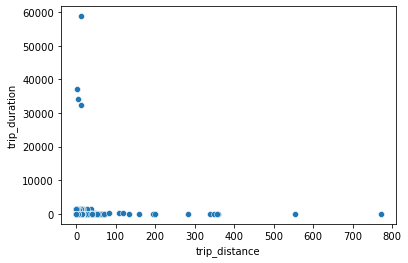

In [40]:
import seaborn as sns
sns.scatterplot(data=sample_df, x="trip_distance", y="trip_duration")

In [43]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state = 42, contamination = 0.01)
sample_df['Anomaly'] = clf.fit_predict(sample_df[['trip_distance', 'trip_duration']])
sample_df.Anomaly.value_counts()

 1    1444099
-1      14545
Name: Anomaly, dtype: int64

## LightGBM Model
We'll compare model performance with and without the weather data. We'll use the Root Mean Squared Logaritmic Error as our evaluation metric

In [27]:
X = sample_df.drop(["trip_duration", "id", "vendor_id", "pickup_datetime", "dropoff_datetime"], axis=1)
y = sample_df["trip_duration"]

In [28]:
#Split the data into training, test, and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [29]:
!pip install lightgbm
import lightgbm as lgb
params = {
    'boosting':'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'learning_rate':0.05,
    'max_depth':14,
    'subsample':0.9,
    'colsample_bytree':0.7,
    'verbosity':1    
}
nrounds = 2000

Converting training data to LightGBM format 

In [30]:
#Define train and validation sets
dtrain = lgb.Dataset(X_train, np.log(y_train+1),free_raw_data=False)
dval = lgb.Dataset(X_val, np.log(y_val+1), reference=dtrain,free_raw_data=False)

#this is for tracking the error
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [34]:
bst = lgb.train(params,
                dtrain,
                num_boost_round = nrounds,
                valid_sets = [dtrain, dval],
                valid_names = ['train', 'valid'],
                )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\Riona\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2800
[LightGBM] [Info] Number of data points in the train set: 765787, number of used features: 25
[LightGBM] [Info] Start training from score 2.487283


In [35]:
#Test predictions
pred = np.exp(bst.predict(X_test)) - 1

In [36]:
#Use mean absolute error to get a basic estimate of the error
mae = (abs(pred - y_test)).mean()
mae

4.949824054488956

In [ ]:
import pickle
filename = "LightGBM_model.sav"
pickle.dump(bst, open(filename, 'wb'))